In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import theano 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
%matplotlib inline
import myutil_lstm as myutil

Using TensorFlow backend.


In [2]:
import importlib
_ = importlib.reload(myutil)

## Get data and take first look at dataset

In [3]:
dfx_train = myutil.get_indexed_dataset('data/dengue_features_train.csv')
dfy_train = myutil.get_indexed_dataset('data/dengue_labels_train.csv')
dfx_test = myutil.get_indexed_dataset('data/dengue_features_test.csv')
# combine training features with training labels for data exploration later on
dftrain = myutil.set_index(pd.merge(dfx_train, dfy_train))
dftrain.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
yearweekofyear,,,,,,,,,,,,,,,,,,,,,
199018,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
199019,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
199020,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
199021,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
199022,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


## Deal with NaN on both training and test datasets together

In [4]:
#dftrain.dtypes
#dftrain.isnull().sum()
#dftest.isnull().sum()
# Will stack the train and test datasets to treat all NaN values together
# Need to add bogus total_cases column to test dataset so the files can be easily concatenated
# update total_cases = -1 to easily identify the records for later split data to original partitions
dfx_test['total_cases'] = -1
dfall = myutil.set_index(pd.concat((dftrain, dfx_test), axis=0))
dfall.sort_index(axis=0, inplace=True)
dfall.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
yearweekofyear,,,,,,,,,,,,,,,,,,,,,
199018,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
199019,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
199020,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
199021,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
199022,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
dfall.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  237
ndvi_nw                                   63
ndvi_se                                   23
ndvi_sw                                   23
precipitation_amt_mm                      15
reanalysis_air_temp_k                     12
reanalysis_avg_temp_k                     12
reanalysis_dew_point_temp_k               12
reanalysis_max_air_temp_k                 12
reanalysis_min_air_temp_k                 12
reanalysis_precip_amt_kg_per_m2           12
reanalysis_relative_humidity_percent      12
reanalysis_sat_precip_amt_mm              15
reanalysis_specific_humidity_g_per_kg     12
reanalysis_tdtr_k                         12
station_avg_temp_c                        55
station_diur_temp_rng_c                   55
station_max_temp_c                        23
station_mi

In [6]:
dfall = myutil.set_nan_to_week_mean(dfall.copy())
dfall.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

## Split dataset

In [7]:
dfall_iq, dfall_sj = myutil.split_dataset_by_city(dfall)

## Continue preprosessing

In [8]:
# drop unnecessary columns
def drop_columns(df):
    df.drop(['city','year','week_start_date'], axis=1, inplace=True)
    return df

dfall_iq = drop_columns(dfall_iq.copy())
dfall_sj = drop_columns(dfall_sj.copy())

## Restore training and test partitions (now that NaNs have been properly filled)

In [9]:
dftrain_iq = dfall_iq[dfall_iq['total_cases']>0].copy()     # total_cases was set to -1 for test partition
dftrain_sj = dfall_sj[dfall_sj['total_cases']>0].copy()     # total_cases was set to -1 for test partition

dftest_iq = dfall_iq[dfall_iq['total_cases']<0].copy()
dftest_sj = dfall_sj[dfall_sj['total_cases']<0].copy()
dftest_iq.drop('total_cases', axis=1, inplace=True)
dftest_sj.drop('total_cases', axis=1, inplace=True)

In [10]:
# split dataset into test and validation partitions
def prep_LSTM_run(city_data, timesteps):
    
    X = city_data[:,:-1]
    y = city_data[:,-1]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

    # LSTM exped 3D input of the form [no_samples, timesteps, no_features] 
    X_train = X_train.reshape(X_train.shape[0], timesteps, int(X_train.shape[1]/timesteps))
    X_valid = X_valid.reshape(X_valid.shape[0], timesteps, int(X_valid.shape[1]/timesteps))
    
    return X_train, X_valid, y_train, y_valid


def LSTM_run_iq(nptrain, timesteps=1, epochs=50, batch_size=32, exploring=False):
    
    # create partitions for training
    X_train, X_valid, y_train, y_valid = prep_LSTM_run(nptrain, timesteps)
    if exploring: print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    # build graph
    model = Sequential()
    
    #keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', 
    #              use_bias=True, kernel_initializer='glorot_uniform', 
    #              recurrent_initializer='orthogonal', bias_initializer='zeros', 
    #              unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
    #              bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
    #              recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
    #              recurrent_dropout=0.0, implementation=1, return_sequences=False, 
    #              return_state=False, go_backwards=False, stateful=False, unroll=False)

    model.add(LSTM((X_train.shape[1]*X_train.shape[2])*2, return_sequences=True,\
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(X_train.shape[1]*X_train.shape[2], return_sequences=True))
    model.add(LSTM(X_train.shape[1], return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='rmsprop')  # 'rmsprop'
    
    # fit net
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    
    if exploring:
        print("Final loss train: {}".format(history.history['loss'][-1]))
        print("Final loss valid: {}".format(history.history['val_loss'][-1]))

    plt.legend()
    plt.show()
    
    return model

# Get test dataset, create predictions and save them in the proper submission file format
def LSTM_predict_and_save(df_iq, model_iq, ts_iq, df_sj, model_sj, ts_sj, dftest_iq, dftest_sj, filename):

    nptest_iq = myutil.preprocess_test(df_iq.copy(), dftest_iq, ts_iq)
    nptest_sj = myutil.preprocess_test(df_sj.copy(), dftest_sj, ts_sj)

    yhat_iq = model_iq.predict(nptest_iq.reshape(nptest_iq.shape[0], ts_iq, int(nptest_iq.shape[1]/ts_iq)))
    yhat_sj = model_sj.predict(nptest_sj.reshape(nptest_sj.shape[0], ts_sj, int(nptest_sj.shape[1]/ts_sj)))
    
    #print(yhat_iq.shape)
    #print(yhat_sj.shape)

    dfsubm = pd.read_csv('data/submission_format.csv')
    npsubm_sj = np.concatenate((dfsubm[dfsubm['city']=='sj'][['city','year','weekofyear']].values, \
                                yhat_sj.round().astype('int64')), axis=1)
    npsubm_iq = np.concatenate((dfsubm[dfsubm['city']=='iq'][['city','year','weekofyear']].values, \
                                yhat_iq.round().astype('int64')), axis=1)
    dfresults = pd.DataFrame(np.concatenate((npsubm_sj, npsubm_iq), axis=0), columns=dfsubm.columns)
    dfresults.to_csv(filename, index=False)
    

(282, 2, 21) (140, 2, 21) (282,) (140,)
Final loss train: 5.988491017767724
Final loss valid: 6.7653182642800465


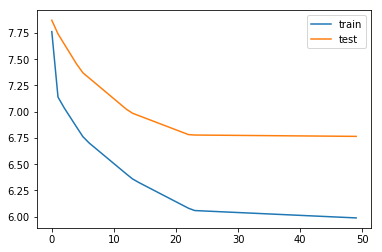

In [11]:
periods_iq = 2
nptrain_iq = myutil.preprocess(dftrain_iq.copy(), periods_iq)
model_iq = LSTM_run_iq(nptrain_iq, timesteps=periods_iq, epochs=50, batch_size=periods_iq*2, exploring=True)

In [12]:
def LSTM_run_sj(nptrain, timesteps=1, epochs=50, batch_size=32, exploring=False):
    
    # create partitions for training
    X_train, X_valid, y_train, y_valid = prep_LSTM_run(nptrain, timesteps)
    if exploring: print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    # build graph
    model = Sequential()
    
    #keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', 
    #              use_bias=True, kernel_initializer='glorot_uniform', 
    #              recurrent_initializer='orthogonal', bias_initializer='zeros', 
    #              unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
    #              bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
    #              recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
    #              recurrent_dropout=0.0, implementation=1, return_sequences=False, 
    #              return_state=False, go_backwards=False, stateful=False, unroll=False)

    model.add(LSTM((X_train.shape[1]*X_train.shape[2])*4, return_sequences=True,\
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM((X_train.shape[1]*X_train.shape[2])*2, return_sequences=True))
    model.add(LSTM((X_train.shape[1]*X_train.shape[2])*1, return_sequences=True))
    model.add(LSTM(X_train.shape[1], return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='rmsprop')  # 'rmsprop'
    
    # fit net
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    
    if exploring:
        print("Final loss train: {}".format(history.history['loss'][-1]))
        print("Final loss valid: {}".format(history.history['val_loss'][-1]))

    plt.legend()
    plt.show()
    
    return model

(623, 2, 21) (307, 2, 21) (623,) (307,)
Final loss train: 24.14688283329408
Final loss valid: 26.04167079304251


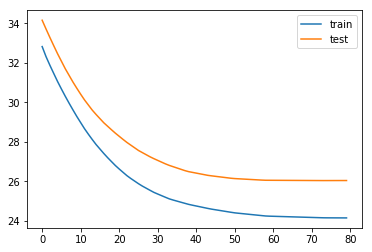

In [16]:
periods_sj = 2
nptrain_sj = myutil.preprocess(dftrain_sj.copy(), periods_sj)
model_sj = LSTM_run_sj(nptrain_sj, timesteps=periods_sj, epochs=80, batch_size=periods_iq*2, exploring=True)

## Get test dataset and create predictions

In [14]:
LSTM_predict_and_save(dftrain_iq, model_iq, periods_iq, dftrain_sj, model_sj, periods_sj, dftest_iq, dftest_sj,\
                      "data/submission_20171122_lstm.csv")